In [1]:
%pylab inline
import scipy.constants as C
import numpy as np
from matplotlib import pyplot



Populating the interactive namespace from numpy and matplotlib


In [2]:
class Hydrogen:
    """
    members give hydrogen thermodynamic properties as a function of temperature in SI units
    presently using NIST properties without accounting for changes due to pressure,
    for an ideal gas, enthalpy is independent of pressure
    for an ideal gas, entropy decreases with pressure with a factor of -nR/P
    http://webbook.nist.gov/cgi/cbook.cgi?ID=C1333740&Type=JANAFG&Table=on#JANAFG
    """
    def getConstants(T):
        """returns constants for equations for use in internal functions"""
        if T < 1000:
            if T < 298:
                warnings.warn('temperature {0} out of range. must be greater than 298 K'.format(T))
            A = 33.066178
            B = -11.363417
            C = 11.432816
            D = -2.772874
            E = -0.158558
            F = -9.980797
            G = 172.707974
            H = 0
        elif T < 2500:
            A = 18.563083
            B = 12.257357
            C = -2.859786
            D = 0.268238
            E = 1.977990
            F = -1.147438
            G = 156.288133
            H = 0
        else:
            A = 43.413560
            B = -4.293079
            C = 1.272428
            D = -0.096876
            E = -20.533862
            F = -38.515158
            G = 162.081354
            H = 0
            if T > 6000:
                warnings.warn('temperature {0} out of range. must be less than 6000 K'.format(T))
        
        return A, B, C, D, E, F, G, H
    
    def MM():
        """molecular mass in kilograms"""
        return 2.01588 * C.u
    
    def gamma(T):
        """heat capacity ratio C_p / C_v"""
        return Hydrogen.C_p(T) / Hydrogen.C_v(T)
    
    def C_p(T):
        """heat capacity at standard pressure in J/mol*K"""
        A, B, C, D, E, F, G, H = Hydrogen.getConstants(T)
        t = T / 1000
        return  A + B*t + C*t**2 + D*t**3 + E/t**2
    
    def C_v(T):
        """constant volume heat capacity in J/mol*K"""
        return Hydrogen.C_p(T) - C.R
        
    def H(T):
        """enthalpy relative to STP in J/mol*K"""
        A, B, C, D, E, F, G, H = Hydrogen.getConstants(T)
        t = T / 1000
        return A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    
    def S(T):
        """standard entropy in J/mol*K"""
        A, B, C, D, E, F, G, H = Hydrogen.getConstants(T)
        t = T / 1000
        return A*log(t) + B*t + C*t**2/2 + D*t**3/3 - E/(2*t**2) + G
    
    def mu(T):
        """
        dynamic viscosity in pascal seconds
        variation with pressure is less than 10% for pressure under 3.45 MPa
        not very reliable at temperatures above 1000 K
        """
        if T > 1000:
            pass #warnings.warn('formula for viscosity is unreliable at above 1000K. given temp = {0}'.format(T))
        return 0.636236562e-6 * T**(3/2) / (T + 72) #Sutherland's formula
        
    def runTests():
        """returns false if a value doesn't match the values in the NIST table"""
        tests = [
        [298.0, 28.84, 130.7, -0.00],
        [300.0, 28.85, 130.9, 0.05, 9e-6],
        [700.0, 29.44, 155.6, 11.75, 16e-6],
        [800.0, 29.62, 159.5, 14.70],
        [1000., 30.21, 166.2, 20.68, 20.3e-6],
        [1300., 31.42, 174.3, 29.92],
        [1700., 33.14, 182.9, 42.83],
        [2100., 34.62, 190.1, 56.40],
        [3200., 37.53, 205.3, 96.20],
        [6000., 41.97, 230.3, 208.3]
        ]
        
        passed = True
        
        for test in tests:
            T = test[0]
            if abs(Hydrogen.C_p(T) - test[1]) > 0.01:
                print(test, 'C_p', Hydrogen.C_p(T))
                passed = False
            if abs(Hydrogen.S(T) - test[2]) > 0.1:
                print(test, 'S', Hydrogen.S(T))
                passed = False
            if abs(Hydrogen.H(T) - test[3]) > 0.05:
                print(test, 'H', Hydrogen.H(T))
                passed = False
            if len(test) > 4 and abs(1 - Hydrogen.mu(T) / test[4]) > 0.15:
                print(test, 'mu', Hydrogen.mu(T))
                passed = False
            #This doesn't hold up at very high temperatures    
            if T < 700 and abs(Hydrogen.gamma(T) - 7/5) > 0.02: #7/5 is the theoretical value for a diatomic gas
                print(test, 'gamma', Hydrogen.gamma(T))
                passed = False
            if abs(Hydrogen.gamma(T) - Hydrogen.C_p(T) / Hydrogen.C_v(T)) > 0.0001:
                print(test, 'C_v', Hydrogen.C_v(T))
                passed = False
            
        return passed
        

In [3]:
H2 = Hydrogen

testPassed = H2.runTests()

if testPassed:
    print("tests passed for hydrogen properties class")
else:
    print("TEST FAILED. THIS IS BAD. FIX THIS.")

tests passed for hydrogen properties class


In [4]:
class Flow1D:
    """represents a one dimensional compressible gas flow"""
    def __init__(self, gas, m_dot, T_0, P_0, r):
        self.gas = gas #class with gas properties to be used
        self.m_dot = m_dot #mass flow rate in kg / s
        self.T = [T_0] #temperature in kelvins at each point
        self.P = [P_0] #pressure in pascals at each point
        self.T_stag = [T_0] #stagnation temperature at each point
        self.r = r #flow radius at each point
        self.M = [self.v()[0] / sqrt(gas.gamma(self.T[0]) * self.P[0] / self.rho()[0])] #Mach number at each point
    
    def rho(self):
        """density at each point in kg/m^3"""
        #using the ideal gas law
        return [self.gas.MM() * P / (C.k * T) for P, T in zip(self.P, self.T)]
    
    def v(self):
        """velocity at each point in m/s"""
        #using mass flow continuity
        return [self.m_dot / (rho * A) for rho, A in zip(self.rho(), self.A())]
    
    def A(self):
        """area of flow at each point in m^2"""
        return [pi * r**2 for r in self.r]
    

In [5]:
def solveFlow(gas, m_dot, T_0, P_0, x, r, q, roughness, printProgress = True):
    """
    calculates 1D laminar ideal gas flow by numerically integrating equations from
    
    Bandyopadhyay and Majumdar
    Modeling of Compressible Flow with Friction and Heat Transfer using
    the Generalized Fluid System Simulation Program (GFSSP)
    
    and
    
    Cantwell
    AA210 Fundamentals of Compressible Flow Chapter 11

    gas -- reference to class with gas properties
    m_dot -- mass flow rate in kg/s
    T_0 -- inlet temperature in kelvins
    P_0 -- inlet pressure in pascals
    x -- array with points along the flow in meters where properties are calculated
    r -- pipe radius at each point in meters
    q -- heat flux into the flow in segment after each point in watt / meter^2, last value is unused
    roughness -- absolute pipe surface roughness at each point in meters
    
    
    spacing between points is assumed to be small enough that values from previous point are used
    as the average value between two points, since this is just inregrating numerically
    """
    
    if min(len(r), len(q), len(roughness)) < len(x)-1:
        raise IndexError("heat flux and pipe radius must be defined for all points!")
       
    f = Flow1D(gas, m_dot, T_0, P_0, r)
    
    for i in range(1, len(x)):
        if printProgress:
            if i % 10**int(log(len(x)/3)/log(10)) == 0:
                print("i = {0}, x = {1}, T = {2}".format(i, x[i], f.T[i-1]))
        
        dx = x[i] - x[i - 1]
        
        Re = m_dot / (pi * r[i-1]**2) * 2*r[i-1] / gas.mu(f.T[i-1]) #Reynold's number
        
        if Re < 2300: #laminar flow
            f_D = 64 / Re #Darcy friction factor assuming laminar flow
        elif Re < 4000: #transition region
            f_D = 0.316 * Re**(-1/4) #Blasius friction factor
        else: #turbulent flow
            f_D = 1.325 / log(roughness[i-1] / (3.7*2*r[i-1]) + 5.74 / Re**0.9)**2 #Swamee-Jain equation
        
        
        power = q[i-1] * (2*pi*r[i-1]) * dx
        C_p = gas.C_p(f.T[-1]) / H2.MM() / C.N_A #C_p in per kg units instead of per mol
        dT_stag = power / (m_dot * C_p)
        f.T_stag.append(f.T_stag[i-1] + dT_stag)
        
        A = pi * r[i-1]**2
        dA = pi * r[i]**2 - A
        
        M = f.M[i-1]
        gamma = gas.gamma(f.T[i-1])
        #Bandyopadhyay and Majumdar equation
        """dM = ( M * (1 + (gamma-1)/2 * M**2) / (1 - M**2) *
             ( gamma * M**2 * f_D * dx / (2*r[i-1]) + #friction effects
               (1 + gamma * M**2)/2 * dT_stag / f.T_stag[i-1] + #heat effects
               - gamma * M**2 * dA / A )) #area change effects
        """
        
        #Cantwell equation
        dM_sq = (2 * M**2 * ((1 + (gamma-1)/2 * M**2) / (1 - M**2)) *
                (gamma * M**2 * f_D * dx / r[i-1] + #friction effects
                 (1 + gamma * M**2) / 2 * dT_stag / f.T_stag[i-1] + #heat effects
                 - dA / A )) #area change effects
        
        f.M.append(sqrt(f.M[i-1]**2 + dM_sq))
        #f.M.append(f.M[i-1] + dM)
        f.T.append(f.T[0] * f.T_stag[i] / f.T_stag[0] *
                   (1 + (gamma-1)/2 * f.M[0]) / (1 + (gamma-1)/2 * f.M[i]) )
        f.P.append(f.P[0] * (r[0]/r[i])**2 * f.M[0]/f.M[i] * sqrt(f.T[i]/f.T[0]) )
        
        if (f.M[i-1] > 1) != (f.M[i] > 1):
            print("mach 1 at i = {0}, x = {1}, T = {2}".format(i, x[i], f.T[i-1]))
    
    return f
        
    

In [6]:
######### adjustable parameters #########

power = 230e6 #core power in watts
m_dot = 6 #mass flow rate in kg / s
T_0 = 500 #inlet temperature in kelvins
P_0 = 4e6 #inlet pressure in pascals

num_channels = 421 * 19
radius = 1.25e-3 #meters
length = 1 #meters
roughnesses = [1e-7, 1e-6, 5e-6, 1e-5]
roughness = 1e-5

#########################################

N = int(1e4)

x = [length / N * i for i in range(N+1)]
r = [radius] * (N+1)
q = [power / num_channels / length / (2*pi*radius)] * N #heat flux

results = []

for roughness in roughnesses:
    result = solveFlow(Hydrogen, m_dot / num_channels, T_0, P_0, x, r, q, [roughness] * N)
    results.append(result)

i = 1000, x = 0.1, T = 761.159531712318
i = 2000, x = 0.2, T = 1017.4742290062479
i = 3000, x = 0.3, T = 1265.8866235673886
i = 4000, x = 0.4, T = 1505.6558530142845
i = 5000, x = 0.5, T = 1737.514916862237
i = 6000, x = 0.6, T = 1962.4990467948217
i = 7000, x = 0.7000000000000001, T = 2181.5148357472613
i = 8000, x = 0.8, T = 2395.2340147023097
i = 9000, x = 0.9, T = 2604.0613808267685
i = 10000, x = 1.0, T = 2807.996380936844
i = 1000, x = 0.1, T = 761.1569093339526
i = 2000, x = 0.2, T = 1017.4650592780341
i = 3000, x = 0.3, T = 1265.8655511547802
i = 4000, x = 0.4, T = 1505.6156217858995
i = 5000, x = 0.5, T = 1737.4452832922682
i = 6000, x = 0.6, T = 1962.3851228453334
i = 7000, x = 0.7000000000000001, T = 2181.334273192384
i = 8000, x = 0.8, T = 2394.9519093996905
i = 9000, x = 0.9, T = 2603.620443719414
i = 10000, x = 1.0, T = 2807.2959344271767
i = 1000, x = 0.1, T = 761.1472382707592
i = 2000, x = 0.2, T = 1017.4306415748989
i = 3000, x = 0.3, T = 1265.785178924683
i = 4000, x

500 2808.19777814
500 2807.49699679
500 2804.46693773
500 2800.69380817


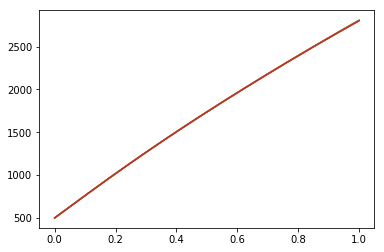

In [7]:
for result in results:
    plot(x, result.T)
    print(result.T[0], result.T[-1])

78.7816428377498 615.905882197
78.7816428377498 623.065091123
78.7816428377498 653.974262413
78.7816428377498 692.378409103


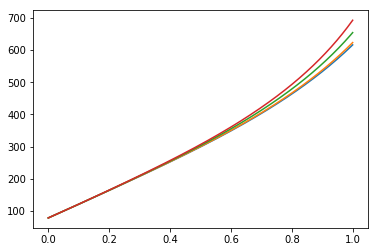

In [8]:
for result in results:
    plot(x, result.v())
    print(result.v()[0], result.v()[-1])

1.939637723266571 0.24810259289
1.939637723266571 0.24525181803
1.939637723266571 0.233660336701
1.939637723266571 0.220699901008


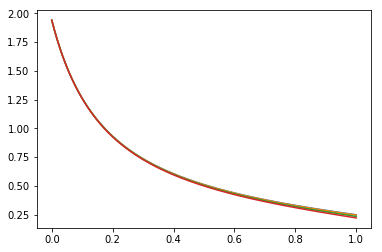

In [9]:
for result in results:
    plot(x, result.rho())
    print(result.rho()[0], result.rho()[-1])

4000000.0 2873613.52791
4000000.0 2839885.96145
4000000.0 2702742.60425
4000000.0 2549395.02899


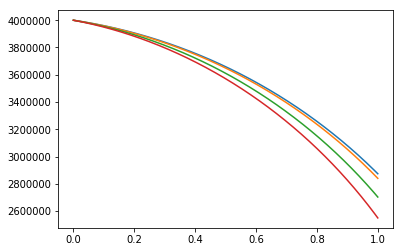

In [10]:
for result in results:
    plot(x, result.P)
    print(result.P[0], result.P[-1])

0.0464161769847 0.153119267484
0.0464161769847 0.154918436733
0.0464161769847 0.162691487953
0.0464161769847 0.172361409756


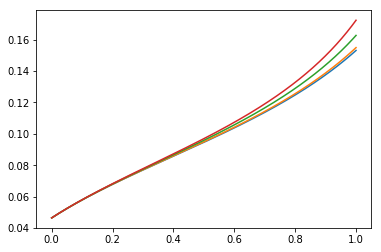

In [11]:
for result in results:
    plot(x, result.M)
    print(result.M[0], result.M[-1])

In [12]:
######### adjustable parameters #########

power = 230e6 #core power in watts
m_dot = 6 #mass flow rate in kg / s
T_0 = 500 #inlet temperature in kelvins
P_0 = 4e6 #inlet pressure in pascals

num_channels = 421 * 19
radius = 1.25e-3 #meters
length = 1 #meters
roughness = 1e-5

#########################################

fineness_values = [int(1e1), int(1e2), int(1e3), int(1e4), int(1e5)]
results = []

for N in fineness_values:
    x = [length / N * i for i in range(N+1)]
    r = [radius] * (N+1)
    q = [power / num_channels / length / (2*pi*radius)] * N #heat flux

    result = solveFlow(Hydrogen, m_dot / num_channels, T_0, P_0, x, r, q, [roughness] * N, False)
    results.append(result)
    
print('done')

done


500 2832.3051232
500 2804.2710244
500 2801.026215
500 2800.69380817
500 2800.6604695


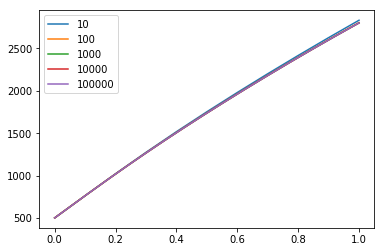

In [13]:
for result, N in zip(results, fineness_values):
    plot([length / N * i for i in range(N+1)], result.T, label=str(N))
    print(result.T[0], result.T[-1])
legend()

78.7816428377498 604.631374639
78.7816428377498 678.988401554
78.7816428377498 691.086912286
78.7816428377498 692.378409103
78.7816428377498 692.508435846


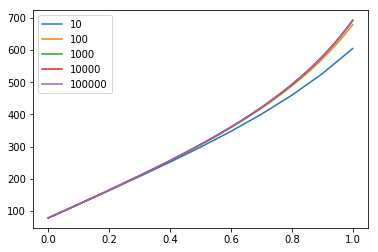

In [14]:
for result, N in zip(results, fineness_values):
    plot([length / N * i for i in range(N+1)], result.v(), label=str(N))
    print(result.v()[0], result.v()[-1])
legend()

1.939637723266571 0.25272893991
1.939637723266571 0.225052218859
1.939637723266571 0.221112342937
1.939637723266571 0.220699901008
1.939637723266571 0.220658461961


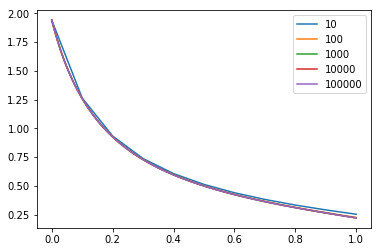

In [15]:
for result, N in zip(results, fineness_values):
    plot([length / N * i for i in range(N+1)], result.rho(), label=str(N))
    print(result.rho()[0], result.rho()[-1])
legend()

4000000.0 2952326.4585
4000000.0 2602990.89362
4000000.0 2554462.4611
4000000.0 2549395.02899
4000000.0 2548886.00799


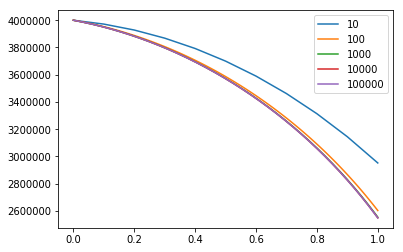

In [16]:
for result, N in zip(results, fineness_values):
    plot([length / N * i for i in range(N+1)], result.P, label=str(N))
    print(result.P[0], result.P[-1])
legend()

0.0464161769847 0.149675251613
0.0464161769847 0.168920244014
0.0464161769847 0.172029694611
0.0464161769847 0.172361409756
0.0464161769847 0.172394804823


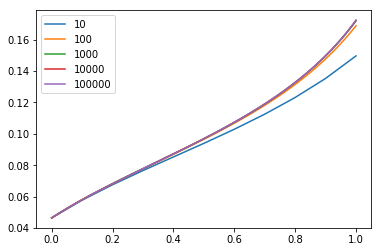

In [17]:
for result, N in zip(results, fineness_values):
    plot([length / N * i for i in range(N+1)], result.M, label=str(N))
    print(result.M[0], result.M[-1])
legend()

In [18]:
######### adjustable parameters #########

power = 230e6 #core power in watts
m_dot = 6 #mass flow rate in kg / s
T_0 = 500 #inlet temperature in kelvins
P_0 = 4e6 #inlet pressure in pascals

num_channels = 421 * 19
radius = 1.25e-3 #meters
length = 1 #meters
roughness = 1e-5

#########################################

N = int(1e3)

x = [length / N * i for i in range(N+1)]
r = [radius] * (N+1)
power_factors = [0.7 + 0.05 * i for i in range(12)]
fluxes = [ [power / num_channels / length / (2*pi*radius) * factor] * N for factor in power_factors]
flow_factors = [0.7 + 0.05 * i for i in range(12)]
flow_rates = [ m_dot * factor for factor in flow_factors]

results = []

for m_dot, q in ((x,y) for x in flow_rates for y in fluxes):
    result = solveFlow(Hydrogen, m_dot / num_channels, T_0, P_0, x, r, q, [roughness] * N, False)
    results.append(result)
    #print(round(m_dot, 1), round(q[0]), round(P_0 - result.P[-1]))

print('done')

done


[ 13.41  13.46  13.51  13.56  13.61  13.65  13.69  13.73  13.77  13.81
  13.85  13.89]
[ 13.5   13.55  13.6   13.65  13.69  13.74  13.78  13.82  13.86  13.9
  13.94  13.97]
[ 13.58  13.63  13.68  13.73  13.78  13.82  13.86  13.91  13.95  13.99
  14.02  14.06]
[ 13.67  13.72  13.77  13.81  13.86  13.9   13.95  13.99  14.03  14.07
  14.11  14.14]
[ 13.75  13.8   13.85  13.89  13.94  13.98  14.03  14.07  14.11  14.15
  14.19  14.23]
[ 13.82  13.87  13.92  13.97  14.02  14.06  14.11  14.15  14.19  14.23
  14.27  14.31]
[ 13.9   13.95  14.    14.05  14.09  14.14  14.18  14.23  14.27  14.31
  14.35  14.39]
[ 13.97  14.02  14.07  14.12  14.17  14.22  14.26  14.31  14.35  14.39
  14.44  14.48]
[ 14.05  14.1   14.15  14.2   14.25  14.29  14.34  14.38  14.43  14.47
  14.52  14.56]
[ 14.12  14.17  14.22  14.27  14.32  14.37  14.42  14.46  14.51  14.56
  14.61  14.65]
[ 14.19  14.24  14.29  14.35  14.4   14.45  14.5   14.55  14.6   14.65
  14.7   14.75]
[ 14.26  14.31  14.37  14.42  14.47  14.52  

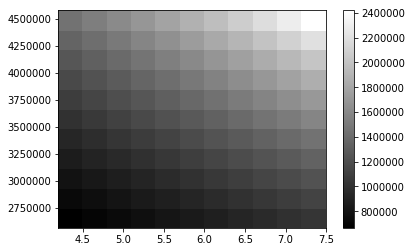

In [19]:
heat_fluxes = [flux[0] for flux in fluxes]
pressure_drops = [P_0 - result.P[-1] for result in results]

pcolor(flow_rates, heat_fluxes, np.reshape(pressure_drops, (12, 12)), cmap='gray')
plt.colorbar()

for row in np.reshape(list(map(lambda x: round(log(x), 2), pressure_drops)), (12, 12)):
    print(row)

In [60]:
######### adjustable parameters #########

power = 230e6 #core power in watts
m_dot = 6 #mass flow rate in kg / s
T_0 = 500 #inlet temperature in kelvins
P_0 = 4e6 #inlet pressure in pascals

num_channels = 421 * 19
radius = 1.25e-3 #meters
length = 1 #meters
roughness = 1e-5

#########################################

N = int(1e3)

flow_rate_elasticity = 1

x = [length / N * i for i in range(N+1)]
r = [radius] * (N+1)
power_factors = [0.7 + 0.05 * i for i in range(12)]
fluxes = [ [power / num_channels / length / (2*pi*radius) * factor] * N for factor in power_factors]
flow_factors = [1] * len(power_factors)
flow_rates = [m_dot * factor for factor in flow_factors]

tolerance = 0.001
done = False
iteration = 0
max_iterations = 100
while not done and iteration < max_iterations:
    results = []
    print(iteration)
    
    for m_dot, q in zip(flow_rates, fluxes):
        result = solveFlow(Hydrogen, m_dot / num_channels, T_0, P_0, x, r, q, [roughness] * N, False)
        results.append(result)
        #print(round(m_dot, 3), round(q[0]), round(result.P[-1]))
        
    pressures = [result.P[-1] for result in results]
    avg = sum(pressures) / len(pressures)
    std_dev = sqrt(sum([x**2 for x in pressures])/len(pressures) - avg**2)
    print(std_dev / avg)
    if std_dev / avg < tolerance:
        done = True
    else:
        flow_rates = [f * exp(log(p/avg) / flow_rate_elasticity) for f, p in zip(flow_rates, pressures)]
        iteration += 1

print('done')

0
0.0845193831766
1
0.0143700168366
2
0.00236979797941
3
0.000342334744302
done


6.00730932281


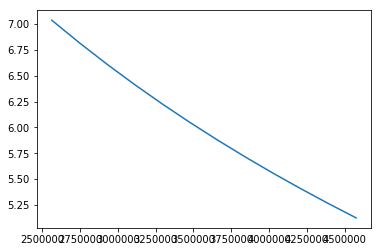

In [61]:
heat_fluxes = [flux[0] for flux in fluxes]
print(sum(flow_rates) / len(flow_rates))
plot(heat_fluxes, flow_rates)

500 1940.3090018
500 2079.79238683
500 2223.78964269
500 2372.37251304
500 2525.63325595
500 2683.64826973
500 2846.47138214
500 3014.23944517
500 3187.07099872
500 3365.08205395
500 3548.40727722
500 3737.23160566


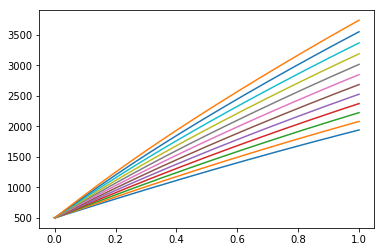

In [49]:
for result in results:
    plot(x, result.T)
    print(result.T[0], result.T[-1])

92.382077711 551.039229075
89.5113990925 572.378669787
86.7883964439 593.477067429
84.2010696732 614.3454288
81.7384575245 634.99603553
79.3919521092 655.443414714
77.1523698668 675.682511898
75.0114585279 695.723499301
72.9617437056 715.56549883
70.9961275883 735.195618018
69.1075780555 754.588680168
67.2887646722 773.706043515


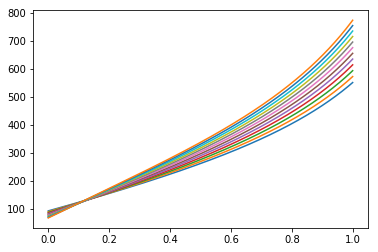

In [50]:
for result in results:
    plot(x, result.v())
    print(result.v()[0], result.v()[-1])

1.939637723266571 0.32518149966
1.939637723266571 0.303330112575
1.939637723266571 0.283647097627
1.939637723266571 0.265843226662
1.939637723266571 0.249675567697
1.939637723266571 0.234942669005
1.939637723266571 0.221476276799
1.939637723266571 0.209127699128
1.939637723266571 0.197772741528
1.939637723266571 0.187306294953
1.939637723266571 0.177638054854
1.939637723266571 0.168689164837


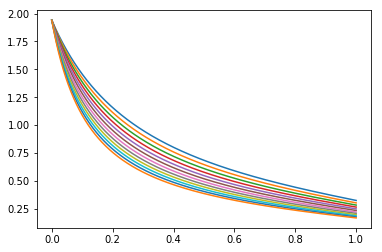

In [51]:
for result in results:
    plot(x, result.rho())
    print(result.rho()[0], result.rho()[-1])

4000000.0 2602352.31947
4000000.0 2601985.52034
4000000.0 2601605.32172
4000000.0 2601224.57362
4000000.0 2600852.35261
4000000.0 2600499.99893
4000000.0 2600179.92502
4000000.0 2599912.14741
4000000.0 2599725.75828
4000000.0 2599665.05777
4000000.0 2599793.39026
4000000.0 2600198.87549


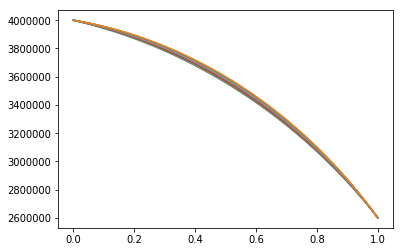

In [52]:
for result in results:
    plot(x, result.P)
    print(result.P[0], result.P[-1])

0.0544292136441 0.164807285102
0.0527378814755 0.165349461782
0.0511335563014 0.1658007257
0.0496091679669 0.166169198858
0.048158258374 0.16646203777
0.0467757559696 0.166687005144
0.045456250029 0.166847077652
0.0441948785212 0.166946429395
0.042987237724 0.16698707604
0.0418291457841 0.166968450664
0.0407164595516 0.16688714764
0.0396448601172 0.166736361197


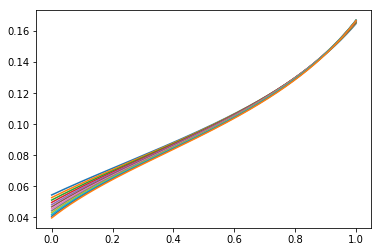

In [53]:
for result in results:
    plot(x, result.M)
    print(result.M[0], result.M[-1])

In [ ]:
########################################
########################################
########################################

"""old version, missing a lot
only here now for reference to make sure new version works"""

########################################
########################################


######### adjustable parameters #########

power = 230e6 #core power in watts
m_dot = 6 #mass flow rate in kg / s
T_0 = 500 #inlet temperature in kelvins
P_0 = 4e6 #inlet pressure in pascals
A = 0.039 #cross-sectional area in m^2

#########################################

rho_0 = H2.MM() * P_0 / (C.k * T_0) #inlet density in kg/m^3 from ideal gas law
v_0 = m_dot / rho_0 / A  #inlet velocity in m/s
Ma_0 = (v_0**2 * H2.MM() / (H2.gamma(T_0) * C.k * T_0))**0.5 #inital Mach number using ideal gas speed of sound

Q = [0] #heat added up to a point
T = [T_0] #temperature at a point
v = [v_0] #velocity at a point
rho = [rho_0] #density at a point
Ma = [Ma_0] #mach number at a point
P = [P_0] #pressure at a point

lists = [Ma, Q, T, v, rho, P]

N = int(1e4) #number of slices; higher N means finer results

delta_q = power / m_dot #total heat per unit mass added in J/kg
dQ = delta_q / N #heat added per unit mass at each step in J/kg

#for each slice of coolant in the channel, add a constant amount of heat
#and apply equations for Rayleigh flow to update temperature and velocity
#Rayleigh flow assumes ideal gas, no friction, constant channel area

reachedMachOne = (Ma[-1] == 1)
i = 0
while i < N and not reachedMachOne:
    i += 1
    if i % 10**int(log(N/3)/log(10)) == 0: #print progress
        print(i)
    
    C_p = H2.C_p(T[-1]) / H2.MM() / C.N_A #C_p in per kg units instead of per mol
    
    Mach_sq = v[-1]**2 * H2.MM() / (H2.gamma(T[-1]) * C.k * T[-1])
    dv = v[-1] * dQ / (C_p * T[-1]) / (1 - Mach_sq) #Eq. 11.121 from Munson Fluid Dynamics Ch. 11.5.2
    dT = (dQ - v[-1]*dv) / C_p #heat not contributing to velocity goes into enthalpy
    
    #update values
    Ma.append(Mach_sq**0.5)
    Q.append(Q[-1] + dQ)
    T.append(T[-1] + dT)
    v.append(v[-1] + dv)
    #using the fact that rho * v is constant by mass flow rate continuity
    rho.append(rho[-1] * v[-2] / v[-1]) #v[-1] is the updated velocity here, v[-2] is v before the update
    P.append(rho[-1] * (C.k * T[-1]) / H2.MM()) #pressure from ideal gas law
    
    #check if further heat addition is possible, otherwise nothing can change; Rayleigh flow cannot cross Mach 1
    if (Ma[-1] < 1) != (Ma[-2] < 1):
        reachedMachOne = True
        
if reachedMachOne:
    print("reached Mach 1 at step {0} out of {1}".format(i, N))
    for x in lists: #remove bad data
        x.pop()


In [ ]:
plot(Q, T)

print(T[:5])
print(T[-5:])

In [ ]:
plot(Q, v)


print(v[:5])
print(v[-5:])

In [ ]:
plot(Q, rho)


print(rho[:5])
print(rho[-5:])

In [ ]:
plot(Q, P)


print(P[:5])
print(P[-5:])

In [ ]:
plot(Q, Ma)


print(Ma[:5])
print(Ma[-5:])